In [1]:
import numpy as np
import h5py
import glob
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
def calculate_f1_score(actual, predictions):
    
    predictions = predictions > 0
    
    total_predicted_positives = predictions.sum()
    total_actual_positives = actual.sum()
    true_positives = (actual*predictions).sum()
    
    precision = true_positives/total_predicted_positives
    recall = true_positives/total_actual_positives
    
    f1_score = 2 * ( precision * recall )/( precision + recall )
    
    return f1_score
    

In [3]:
h5_path = 'training/dataNorm.h5'
path_to_models = 'models/simplest'

In [4]:
import torchvision.transforms.functional as TF
class Road_Segmentation_Database(torch.utils.data.Dataset):
    def __init__(self, training):
        super(Road_Segmentation_Database, self).__init__()
        self.hf = h5py.File(h5_path, 'r')    
        self.training = training
        
        if self.training:
            self.sizeTrain = len(self.hf['train'])
        else:
            self.sizeTrain = len(self.hf['test'])
         

    def __getitem__(self, index):
    
        hfFile = self.hf   
        
        if self.training:
            imgX = hfFile['train'][index, ...]
            imgY = hfFile['train_groundtruth'][index, ...]
        else:
            imgX = hfFile['test'][index, ...]
            imgY = hfFile['test_groundtruth'][index, ...]
        
        tensorX = torch.as_tensor(imgX).float()
        tensorY = torch.as_tensor(imgY).float()
        
        if torch.cuda.is_available():
            tensorX.cuda()
            tensorY.cuda()
        
        return (tensorX, tensorY)
 
    def __len__(self):
        
        return self.sizeTrain 

def load_dataset(training):
    
    dataset = Road_Segmentation_Database(training)

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )
    return loader



In [5]:
trainloader = load_dataset(training=True)
testloader = load_dataset(training=False)

In [6]:
# o = output
# p = padding
# k = kernel_size
# s = stride
# d = dilation
# o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

def get_size_of_padding(output_size, input_size, kernel_size=3, stride=1, dilation=1):
    return (stride*(output_size-1) + kernel_size - input_size + (kernel_size - 1)*(dilation - 1) )/2
output_size = 400
input_size = 400
kernel_size = 3
stride = 1
dilation = 1
print(get_size_of_padding(output_size, input_size, kernel_size, stride, dilation))

1.0


In [7]:
import torch.nn as nn
import torch.nn.functional as F



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=1, padding=1, dilation=1), 
            nn.ReLU(True),
            
            nn.Conv2d(8, 1, 1, stride=1, padding=0, dilation=1),  
            #nn.Sigmoid() done in BCEWithLogitsLoss
        )

    def forward(self, x):
        x = self.network(x)
        return x

if torch.cuda.is_available():
    print("cuda available")
    net.cuda()
net = Net()

In [8]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.BCEWithLogitsLoss(torch.tensor([5]))# nn.BCELoss()

In [9]:
training_f1 = []
validation_f1 = []
trainingLoss = []
validationLoss = []
durations = []
epochSize = 1000
testDataSize = len(testloader)
trainDataSize = len(trainloader)
startAt = 0

In [10]:
# startAt = 0
# modelFolderName = "simple"
# net.load_state_dict(torch.load(path_to_models+'/net_Epoch_#' + str(startAt-1) +'.pt'))
# if torch.cuda.is_available():
#     print("cuda available!")
#     net.cuda()



In [11]:
%%time
import time
start = time.time()

for epoch in range(startAt,epochSize):  # loop over the dataset multiple times

    train_running_loss = 0.0
    test_running_loss = 0.0
    
    train_running_f1 = 0.0
    test_running_f1 = 0.0
    
    
    for i, data in enumerate(trainloader, 0):
        
        if i%20 == 0:
            print('%d' % int((1000 * (i+epoch*trainDataSize)/(trainDataSize*epochSize))) + '‰ done')
    
        # get the inputs
        inputs, trueImage = data
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            trueImage = trueImage.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        outputs = net(inputs)
        loss = criterion(outputs, trueImage)
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_running_loss += loss.item()
        train_running_f1 += calculate_f1_score(trueImage[0].squeeze().numpy(), outputs[0].detach().squeeze().numpy())
        
   
    # epoch done test on validation
        
    for i, data in enumerate(testloader, 0):
        
         # get the inputs
        inputs, trueImage = data
        
        # cuda them
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            trueImage = trueImage.cuda()

        # forward and test

        outputs = net(inputs)
        loss = criterion(outputs, trueImage)
        
        # print statistics
        test_running_loss += loss.item()
        test_running_f1 += calculate_f1_score(trueImage[0].squeeze().numpy(), outputs[0].detach().squeeze().numpy())
    
    # store statistics
    
    trainingLoss.append(train_running_loss/trainDataSize)
    validationLoss.append(test_running_loss/testDataSize)
    
    training_f1.append(train_running_f1/trainDataSize)
    validation_f1.append(test_running_f1/testDataSize)
    print("Current training loss is " + str(train_running_loss/trainDataSize))
    print("Current test loss is " + str(test_running_loss/testDataSize))
    print("Current f1_score for training is " + str(train_running_f1/trainDataSize))
    print("Current f1_score for test is " + str(test_running_f1/testDataSize))
#     print(trainingLoss)
#     print(validationLoss)
    
    
    # save net 
    torch.save(net.state_dict(), path_to_models+'/net_Epoch_#' + str(epoch) +'.pt')
    print("Epoch " + str(epoch))
    end = time.time()
    epochDuration = (end - start)
    durations.append(epochDuration)
    print("Duration of 1 Epoch is " + str(np.mean(durations)/60.0 ) + " minutes")
    print("Estimated " + str(np.mean(durations)/60.0 * (epochSize-epoch+startAt-1) ) + " minutes left until completion" )
    print()
    start = end
    
print()
print('Finished Training')
print()


0‰ done
0‰ done


C:\Users\chest\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
C:\Users\chest\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


0‰ done
Current training loss is 2.8979107618331907
Current test loss is 2.739108440279961
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 0
Duration of 1 Epoch is 0.13489027420679728 minutes
Estimated 134.7553839325905 minutes left until completion

1‰ done
1‰ done
1‰ done
Current training loss is 2.5488937834898633
Current test loss is 2.6437062084674836
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 1
Duration of 1 Epoch is 0.12867947419484457 minutes
Estimated 128.4221152464549 minutes left until completion

2‰ done
2‰ done
2‰ done
Current training loss is 2.4585293889045716
Current test loss is 2.603214156627655
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 2
Duration of 1 Epoch is 0.13315888245900473 minutes
Estimated 132.75940581162772 minutes left until completion

3‰ done
3‰ done
3‰ done
Current training loss is 2.425488644838333
Current test loss is 2.591859596967697
Current f1_score for tr

Current f1_score for test is nan
Epoch 27
Duration of 1 Epoch is 0.13518020808696746 minutes
Estimated 131.39516226053237 minutes left until completion

28‰ done
28‰ done
28‰ done
Current training loss is 2.3530239899953207
Current test loss is 2.5223997294902802
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 28
Duration of 1 Epoch is 0.13530275629854752 minutes
Estimated 131.37897636588963 minutes left until completion

29‰ done
29‰ done
29‰ done
Current training loss is 2.3512510498364767
Current test loss is 2.5195859014987945
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 29
Duration of 1 Epoch is 0.13482462260458206 minutes
Estimated 130.7798839264446 minutes left until completion

30‰ done
30‰ done
30‰ done
Current training loss is 2.3499676485856376
Current test loss is 2.519948011636734
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 30
Duration of 1 Epoch is 0.13434367872053576 minutes
Estima

Estimated 124.96402552127837 minutes left until completion

55‰ done
55‰ done
55‰ done
Current training loss is 2.306302398443222
Current test loss is 2.4809490859508516
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 55
Duration of 1 Epoch is 0.13217700272798538 minutes
Estimated 124.7750905752182 minutes left until completion

56‰ done
56‰ done
56‰ done
Current training loss is 2.302997789780299
Current test loss is 2.4816417425870894
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 56
Duration of 1 Epoch is 0.13202214763875592 minutes
Estimated 124.49688522334682 minutes left until completion

57‰ done
57‰ done
57‰ done
Current training loss is 2.3010454694430034
Current test loss is 2.4770251244306563
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 57
Duration of 1 Epoch is 0.1320399766680838 minutes
Estimated 124.38165802133496 minutes left until completion

58‰ done
58‰ done
58‰ done
Current traini

Current training loss is 2.252705623706182
Current test loss is 2.394821156561375
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 82
Duration of 1 Epoch is 0.1307849083080828 minutes
Estimated 119.92976091851192 minutes left until completion

83‰ done
83‰ done
83‰ done
Current training loss is 2.2497136414051058
Current test loss is 2.3910987615585326
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 83
Duration of 1 Epoch is 0.13088334533903334 minutes
Estimated 119.88914433055454 minutes left until completion

84‰ done
84‰ done
84‰ done
Current training loss is 2.248897337913513
Current test loss is 2.3913867235183717
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 84
Duration of 1 Epoch is 0.13094238145678652 minutes
Estimated 119.81227903295967 minutes left until completion

85‰ done
85‰ done
85‰ done
Current training loss is 2.2494876166184743
Current test loss is 2.3889476656913757
Current f1_score 

Current test loss is 2.3497762814164163
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 109
Duration of 1 Epoch is 0.13026232358181114 minutes
Estimated 115.93346798781191 minutes left until completion

110‰ done
110‰ done
110‰ done
Current training loss is 2.211144842704137
Current test loss is 2.3541563130915164
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 110
Duration of 1 Epoch is 0.1303062293622587 minutes
Estimated 115.84223790304797 minutes left until completion

111‰ done
111‰ done
111‰ done
Current training loss is 2.208740105231603
Current test loss is 2.3487521946430205
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 111
Duration of 1 Epoch is 0.13030013871334847 minutes
Estimated 115.70652317745345 minutes left until completion

112‰ done
112‰ done
112‰ done
Current training loss is 2.207730120420456
Current test loss is 2.3518921226263045
Current f1_score for training is nan
Current f1_s

Current training loss is 2.1668067197004954
Current test loss is 2.3077906504273415
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 136
Duration of 1 Epoch is 0.13095104964110102 minutes
Estimated 113.01075584027018 minutes left until completion

137‰ done
137‰ done
137‰ done
Current training loss is 2.1619024515151977
Current test loss is 2.3085717126727103
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 137
Duration of 1 Epoch is 0.13093872283391905 minutes
Estimated 112.86917908283823 minutes left until completion

138‰ done
138‰ done
138‰ done
Current training loss is 2.15960195461909
Current test loss is 2.3038321629166605
Current f1_score for training is nan
Current f1_score for test is nan
Epoch 138
Duration of 1 Epoch is 0.1309058739698762 minutes
Estimated 112.70995748806342 minutes left until completion

139‰ done
139‰ done
139‰ done
Current training loss is 2.1564834276835123
Current test loss is 2.3027827717363833
Curr

Current f1_score for test is 0.08273485452195381
Epoch 161
Duration of 1 Epoch is 0.13113041537288775 minutes
Estimated 109.88728808247993 minutes left until completion

162‰ done
162‰ done
162‰ done
Current training loss is 2.105947498480479
Current test loss is 2.265355148911476
Current f1_score for training is 0.13343479806511174
Current f1_score for test is 0.16257740432588366
Epoch 162
Duration of 1 Epoch is 0.13109005896835485 minutes
Estimated 109.72237935651302 minutes left until completion

163‰ done
163‰ done
163‰ done
Current training loss is 2.100756149490674
Current test loss is 2.2626937970519068
Current f1_score for training is 0.14701337059332176
Current f1_score for test is 0.15106646876346363
Epoch 163
Duration of 1 Epoch is 0.1311553522096417 minutes
Estimated 109.64587444726045 minutes left until completion

164‰ done
164‰ done
164‰ done
Current training loss is 2.09775310754776
Current test loss is 2.252207863330841
Current f1_score for training is 0.13647098938520

Estimated 106.81968026340648 minutes left until completion

186‰ done
186‰ done
186‰ done
Current training loss is 2.0877744138240812
Current test loss is 2.259188885241747
Current f1_score for training is 0.21422344605364305
Current f1_score for test is 0.24357274421200326
Epoch 186
Duration of 1 Epoch is 0.13116986851428708 minutes
Estimated 106.6411031021154 minutes left until completion

187‰ done
187‰ done
187‰ done
Current training loss is 2.0864584197600684
Current test loss is 2.246059783548117
Current f1_score for training is 0.2271828698305775
Current f1_score for test is 0.19741918897312408
Epoch 187
Duration of 1 Epoch is 0.13117255826368399 minutes
Estimated 106.51211731011139 minutes left until completion

188‰ done
188‰ done
188‰ done
Current training loss is 2.087876263260841
Current test loss is 2.246159774065018
Current f1_score for training is 0.22108457223577366
Current f1_score for test is 0.19102357265150618
Epoch 188
Duration of 1 Epoch is 0.13119020943498697 min

Current test loss is 2.2486338175833227
Current f1_score for training is 0.2615729304475215
Current f1_score for test is 0.2884322021708967
Epoch 210
Duration of 1 Epoch is 0.13101894998625743 minutes
Estimated 103.37395153915712 minutes left until completion

211‰ done
211‰ done
211‰ done
Current training loss is 2.0839984009663266
Current test loss is 2.243692995607853
Current f1_score for training is 0.24853875520376575
Current f1_score for test is 0.2701729710068804
Epoch 211
Duration of 1 Epoch is 0.13108795332083914 minutes
Estimated 103.29730721682124 minutes left until completion

212‰ done
212‰ done
212‰ done
Current training loss is 2.082936351497968
Current test loss is 2.24742878228426
Current f1_score for training is 0.25884560362196346
Current f1_score for test is 0.2872876110948231
Epoch 212
Duration of 1 Epoch is 0.13109928112074803 minutes
Estimated 103.1751342420287 minutes left until completion

213‰ done
213‰ done
213‰ done
Current training loss is 2.079478532075882

Duration of 1 Epoch is 0.13045523586002647 minutes
Estimated 99.79825543292024 minutes left until completion

235‰ done
235‰ done
235‰ done
Current training loss is 2.0867553571859996
Current test loss is 2.246242879331112
Current f1_score for training is 0.2609324579337784
Current f1_score for test is 0.2914621377295759
Epoch 235
Duration of 1 Epoch is 0.13045928308182517 minutes
Estimated 99.67089227451443 minutes left until completion

236‰ done
236‰ done
236‰ done
Current training loss is 2.079779323935509
Current test loss is 2.259093943238258
Current f1_score for training is 0.2665711784165327
Current f1_score for test is 0.300186889118222
Epoch 236
Duration of 1 Epoch is 0.13046914925890465 minutes
Estimated 99.54796088454425 minutes left until completion

237‰ done
237‰ done
237‰ done
Current training loss is 2.0769576887289682
Current test loss is 2.2449479289352894
Current f1_score for training is 0.2544230046529908
Current f1_score for test is 0.2882311326956386
Epoch 237
Du

Current test loss is 2.2477157957851888
Current f1_score for training is 0.2742034001433859
Current f1_score for test is 0.3071048764162354
Epoch 259
Duration of 1 Epoch is 0.13060925572346418 minutes
Estimated 96.6508492353635 minutes left until completion

260‰ done
260‰ done
260‰ done
Current training loss is 2.0793790489435198
Current test loss is 2.246038830280304
Current f1_score for training is 0.2773376248799557
Current f1_score for test is 0.2350272349931167
Epoch 260
Duration of 1 Epoch is 0.13060706549372864 minutes
Estimated 96.51862139986547 minutes left until completion

261‰ done
261‰ done
261‰ done
Current training loss is 2.0777375628550847
Current test loss is 2.248769912868738
Current f1_score for training is 0.27461402642154836
Current f1_score for test is 0.3089292298224138
Epoch 261
Duration of 1 Epoch is 0.1306057946372578 minutes
Estimated 96.38707644229626 minutes left until completion

262‰ done
262‰ done
262‰ done
Current training loss is 2.0787279019753138
C

Duration of 1 Epoch is 0.13064315215522695 minutes
Estimated 93.5404969431425 minutes left until completion

284‰ done
284‰ done
284‰ done
Current training loss is 2.080851599574089
Current test loss is 2.2495809368789197
Current f1_score for training is 0.2803051108740268
Current f1_score for test is 0.28340810454322607
Epoch 284
Duration of 1 Epoch is 0.13066676560898274 minutes
Estimated 93.42673741042266 minutes left until completion

285‰ done
285‰ done
285‰ done
Current training loss is 2.0777094036340715
Current test loss is 2.24397654235363
Current f1_score for training is 0.28793958876061615
Current f1_score for test is 0.2780436619249348
Epoch 285
Duration of 1 Epoch is 0.1306925241485898 minutes
Estimated 93.31446224209313 minutes left until completion

286‰ done
286‰ done
286‰ done
Current training loss is 2.0748632748921714
Current test loss is 2.2509902849793435
Current f1_score for training is 0.2725058590788196
Current f1_score for test is 0.2805593654129093
Epoch 286
D

Current test loss is 2.2624852403998377
Current f1_score for training is 0.28437169512441957
Current f1_score for test is 0.330685613723929
Epoch 308
Duration of 1 Epoch is 0.13071431789583374 minutes
Estimated 90.32359366602111 minutes left until completion

309‰ done
309‰ done
309‰ done
Current training loss is 2.0767121404409408
Current test loss is 2.244169656187296
Current f1_score for training is 0.30527060454421145
Current f1_score for test is 0.2836674574532073
Epoch 309
Duration of 1 Epoch is 0.13070502778535248 minutes
Estimated 90.18646917189321 minutes left until completion

310‰ done
310‰ done
310‰ done
Current training loss is 2.074734987815221
Current test loss is 2.249750251695514
Current f1_score for training is 0.2802136978679671
Current f1_score for test is 0.22273563278949893
Epoch 310
Duration of 1 Epoch is 0.13068708212045993 minutes
Estimated 90.04339958099689 minutes left until completion

311‰ done
311‰ done
311‰ done
Current training loss is 2.074745391805967


Duration of 1 Epoch is 0.13081328654074456 minutes
Estimated 87.25246212267662 minutes left until completion

333‰ done
333‰ done
333‰ done
Current training loss is 2.074248896042506
Current test loss is 2.2458652071654797
Current f1_score for training is 0.27134518570330857
Current f1_score for test is 0.31851951273986173
Epoch 333
Duration of 1 Epoch is 0.13082007879982452 minutes
Estimated 87.12617248068312 minutes left until completion

334‰ done
334‰ done
334‰ done
Current training loss is 2.0802117655674617
Current test loss is 2.2419138796627522
Current f1_score for training is 0.3030460799858031
Current f1_score for test is 0.28075599449943744
Epoch 334
Duration of 1 Epoch is 0.13079656279502222 minutes
Estimated 86.97971425868978 minutes left until completion

335‰ done
335‰ done
335‰ done
Current training loss is 2.0784253646930058
Current test loss is 2.260792741179466
Current f1_score for training is 0.2740400955909503
Current f1_score for test is 0.3481531146728114
Epoch 3

Current test loss is 2.2450015388429163
Current f1_score for training is 0.29219438869507747
Current f1_score for test is 0.29663613170046477
Epoch 357
Duration of 1 Epoch is 0.13075920784051637 minutes
Estimated 83.9474114336115 minutes left until completion

358‰ done
358‰ done
358‰ done
Current training loss is 2.071636524796486
Current test loss is 2.2428698226809503
Current f1_score for training is 0.28458885085340185
Current f1_score for test is 0.28051906280676764
Epoch 358
Duration of 1 Epoch is 0.1307420387020129 minutes
Estimated 83.80564680799027 minutes left until completion

359‰ done
359‰ done
359‰ done
Current training loss is 2.0711765786012015
Current test loss is 2.268501880764961
Current f1_score for training is 0.2861992440510817
Current f1_score for test is 0.32517588183402873
Epoch 359
Duration of 1 Epoch is 0.13071923544009528 minutes
Estimated 83.66031068166097 minutes left until completion

360‰ done
360‰ done
360‰ done
Current training loss is 2.07620236277580

Duration of 1 Epoch is 0.13118788959884312 minutes
Estimated 81.07411577208505 minutes left until completion

382‰ done
382‰ done
382‰ done
Current training loss is 2.0808626055717467
Current test loss is 2.250981117039919
Current f1_score for training is 0.26257206730403887
Current f1_score for test is 0.31826536676411543
Epoch 382
Duration of 1 Epoch is 0.13121467025721975 minutes
Estimated 80.95945154870459 minutes left until completion

383‰ done
383‰ done
383‰ done
Current training loss is 2.0712473253409067
Current test loss is 2.2622349344193937
Current f1_score for training is 0.2917043918518375
Current f1_score for test is 0.32182977958654363
Epoch 383
Duration of 1 Epoch is 0.13122620824724435 minutes
Estimated 80.83534428030252 minutes left until completion

384‰ done
384‰ done
384‰ done
Current training loss is 2.073580527305603
Current test loss is 2.2492807399481536
Current f1_score for training is 0.30194700906823707
Current f1_score for test is 0.23414665012524466
Epoch

Current test loss is 2.259271004796028
Current f1_score for training is 0.28395102346740625
Current f1_score for test is 0.3105408437545158
Epoch 406
Duration of 1 Epoch is 0.13142215843380328 minutes
Estimated 77.93333995124534 minutes left until completion

407‰ done
407‰ done
407‰ done
Current training loss is 2.0687416503826777
Current test loss is 2.247806191444397
Current f1_score for training is 0.28378501303878345
Current f1_score for test is 0.31871472611082924
Epoch 407
Duration of 1 Epoch is 0.13141212832499174 minutes
Estimated 77.79597996839512 minutes left until completion

408‰ done
408‰ done
408‰ done
Current training loss is 2.0699426203966143
Current test loss is 2.2438767019659283
Current f1_score for training is 0.31531229254607557
Current f1_score for test is 0.2547893160106759
Epoch 408
Duration of 1 Epoch is 0.13141136503647086 minutes
Estimated 77.66411673655428 minutes left until completion

409‰ done
409‰ done
409‰ done
Current training loss is 2.0744989842176

Duration of 1 Epoch is 0.13146707626248363 minutes
Estimated 74.80476639335319 minutes left until completion

431‰ done
431‰ done
431‰ done
Current training loss is 2.067548653483391
Current test loss is 2.2406894218176605
Current f1_score for training is 0.30112068686700166
Current f1_score for test is 0.28678090707675385
Epoch 431
Duration of 1 Epoch is 0.13149218126947498 minutes
Estimated 74.6875589610618 minutes left until completion

432‰ done
432‰ done
432‰ done
Current training loss is 2.0692464898029965
Current test loss is 2.247185131162405
Current f1_score for training is 0.2950695735865072
Current f1_score for test is 0.31615034202681813
Epoch 432
Duration of 1 Epoch is 0.13147864199492268 minutes
Estimated 74.54839001112116 minutes left until completion

433‰ done
433‰ done
433‰ done
Current training loss is 2.0712455958127975
Current test loss is 2.243439617007971
Current f1_score for training is 0.2884744546236105
Current f1_score for test is 0.311943909570123
Epoch 433


Current test loss is 2.252011776715517
Current f1_score for training is 0.292754499711949
Current f1_score for test is 0.31847115184813635
Epoch 455
Duration of 1 Epoch is 0.13156364174091328 minutes
Estimated 71.57062110705682 minutes left until completion

456‰ done
456‰ done
456‰ done
Current training loss is 2.063365841905276
Current test loss is 2.2403932452201842
Current f1_score for training is 0.3084578770993213
Current f1_score for test is 0.25499373744184617
Epoch 456
Duration of 1 Epoch is 0.13158223743772612 minutes
Estimated 71.44915492868529 minutes left until completion

457‰ done
457‰ done
457‰ done
Current training loss is 2.0722840398550035
Current test loss is 2.248825964331627
Current f1_score for training is 0.28390919083551913
Current f1_score for test is 0.2906913834088882
Epoch 457
Duration of 1 Epoch is 0.13156725849300147 minutes
Estimated 71.30945410320679 minutes left until completion

458‰ done
458‰ done
458‰ done
Current training loss is 2.0675647189219792

Duration of 1 Epoch is 0.13150414674646324 minutes
Estimated 68.38215630816089 minutes left until completion

480‰ done
480‰ done
480‰ done
Current training loss is 2.0679900338252386
Current test loss is 2.251737841963768
Current f1_score for training is 0.30404400431575296
Current f1_score for test is 0.3173550834638517
Epoch 480
Duration of 1 Epoch is 0.13149212690500114 minutes
Estimated 68.2444138636956 minutes left until completion

481‰ done
481‰ done
481‰ done
Current training loss is 2.067313744624456
Current test loss is 2.24530540779233
Current f1_score for training is 0.30833094433562336
Current f1_score for test is 0.2351220538015923
Epoch 481
Duration of 1 Epoch is 0.13148826820721765 minutes
Estimated 68.11092293133875 minutes left until completion

482‰ done
482‰ done
482‰ done
Current training loss is 2.0700394848982495
Current test loss is 2.236602893471718
Current f1_score for training is 0.27873268146794616
Current f1_score for test is 0.31742917108367086
Epoch 482


Current test loss is 2.245757833123207
Current f1_score for training is 0.2808302959610219
Current f1_score for test is 0.3090859574291395
Epoch 504
Duration of 1 Epoch is 0.13144092594436294 minutes
Estimated 65.06325834245965 minutes left until completion

505‰ done
505‰ done
505‰ done
Current training loss is 2.065614343682925
Current test loss is 2.25870600938797
Current f1_score for training is 0.3067568001026328
Current f1_score for test is 0.3128757042066336
Epoch 505
Duration of 1 Epoch is 0.1314327301950794 minutes
Estimated 64.92776871636921 minutes left until completion

506‰ done
506‰ done
506‰ done
Current training loss is 2.0680374761422473
Current test loss is 2.236119444668293
Current f1_score for training is 0.30435329862215627
Current f1_score for test is 0.28916366113154257
Epoch 506
Duration of 1 Epoch is 0.13143448587470272 minutes
Estimated 64.79720153622844 minutes left until completion

507‰ done
507‰ done
507‰ done
Current training loss is 2.0634177883466083
Cu

Duration of 1 Epoch is 0.13150493587873685 minutes
Estimated 61.93882479888506 minutes left until completion

529‰ done
529‰ done
529‰ done
Current training loss is 2.0642244547605513
Current test loss is 2.2491644598543643
Current f1_score for training is 0.3058059369752582
Current f1_score for test is 0.3009066817668574
Epoch 529
Duration of 1 Epoch is 0.13150060743655798 minutes
Estimated 61.80528549518225 minutes left until completion

530‰ done
530‰ done
530‰ done
Current training loss is 2.0711285322904587
Current test loss is 2.2333977267146112
Current f1_score for training is 0.30381517803301156
Current f1_score for test is 0.26789469083723433
Epoch 530
Duration of 1 Epoch is 0.13152118125802978 minutes
Estimated 61.683434010015965 minutes left until completion

531‰ done
531‰ done
531‰ done
Current training loss is 2.066140008966128
Current test loss is 2.2626760736107827
Current f1_score for training is 0.28095203186033646
Current f1_score for test is 0.3522031839465064
Epoch

Current test loss is 2.2328807454556228
Current f1_score for training is 0.298506106752723
Current f1_score for test is 0.27055553203601274
Epoch 553
Duration of 1 Epoch is 0.13155312858764015 minutes
Estimated 58.67269535008751 minutes left until completion

554‰ done
554‰ done
554‰ done
Current training loss is 2.0627152413129806
Current test loss is 2.260518866032362
Current f1_score for training is 0.2939885880392251
Current f1_score for test is 0.3401116633720091
Epoch 554
Duration of 1 Epoch is 0.13155494613332433 minutes
Estimated 58.541951029329326 minutes left until completion

555‰ done
555‰ done
555‰ done
Current training loss is 2.0610739558935167
Current test loss is 2.2309972777962686
Current f1_score for training is 0.3062169230269913
Current f1_score for test is 0.31510795710495987
Epoch 555
Duration of 1 Epoch is 0.1315582307980215 minutes
Estimated 58.41185447432155 minutes left until completion

556‰ done
556‰ done
556‰ done
Current training loss is 2.063813067475954

Duration of 1 Epoch is 0.1315905406332071 minutes
Estimated 55.5312081472134 minutes left until completion

578‰ done
578‰ done
578‰ done
Current training loss is 2.059389926989873
Current test loss is 2.2284419827163218
Current f1_score for training is 0.31120377653292963
Current f1_score for test is 0.3086308938697138
Epoch 578
Duration of 1 Epoch is 0.13158619666003465 minutes
Estimated 55.39778879387459 minutes left until completion

579‰ done
579‰ done
579‰ done
Current training loss is 2.0589772423108417
Current test loss is 2.241385151445866
Current f1_score for training is 0.3125572558674948
Current f1_score for test is 0.3026058624142916
Epoch 579
Duration of 1 Epoch is 0.1315823761622111 minutes
Estimated 55.26459798812866 minutes left until completion

580‰ done
580‰ done
580‰ done
Current training loss is 2.0576334675153096
Current test loss is 2.2438728634268044
Current f1_score for training is 0.3077754607521873
Current f1_score for test is 0.2265645463371566
Epoch 580
Du

Current test loss is 2.230509779602289
Current f1_score for training is 0.30791063316274603
Current f1_score for test is 0.2808238615791464
Epoch 602
Duration of 1 Epoch is 0.13148562123328694 minutes
Estimated 52.199791629614914 minutes left until completion

603‰ done
603‰ done
603‰ done
Current training loss is 2.0670227319002152
Current test loss is 2.2400113739073277
Current f1_score for training is 0.2920634767849742
Current f1_score for test is 0.3214420233157994
Epoch 603
Duration of 1 Epoch is 0.1314847407554159 minutes
Estimated 52.067957339144705 minutes left until completion

604‰ done
604‰ done
604‰ done
Current training loss is 2.059075590968132
Current test loss is 2.2324936196208
Current f1_score for training is 0.2970629562043296
Current f1_score for test is 0.3107148573365816
Epoch 604
Duration of 1 Epoch is 0.13148067419850792 minutes
Estimated 51.93486630841063 minutes left until completion

605‰ done
605‰ done
605‰ done
Current training loss is 2.056875459353129
Cu

Duration of 1 Epoch is 0.13136750018577636 minutes
Estimated 49.00007756929458 minutes left until completion

627‰ done
627‰ done
627‰ done
Current training loss is 2.0616467485825223
Current test loss is 2.2262828536331654
Current f1_score for training is 0.29867719114310604
Current f1_score for test is 0.3136260005681762
Epoch 627
Duration of 1 Epoch is 0.131362698298351 minutes
Estimated 48.866923766986574 minutes left until completion

628‰ done
628‰ done
628‰ done
Current training loss is 2.0552488257487616
Current test loss is 2.233111101388931
Current f1_score for training is 0.30731954376893944
Current f1_score for test is 0.3223920593357129
Epoch 628
Duration of 1 Epoch is 0.1313601868078073 minutes
Estimated 48.734629305696515 minutes left until completion

629‰ done
629‰ done
629‰ done
Current training loss is 2.058964516719182
Current test loss is 2.2277715012431143
Current f1_score for training is 0.30845224435688584
Current f1_score for test is 0.3063424319754348
Epoch 62

Current test loss is 2.231568618863821
Current f1_score for training is 0.3127112723813736
Current f1_score for test is 0.3172628931003488
Epoch 651
Duration of 1 Epoch is 0.1313232558027123 minutes
Estimated 45.70049301934389 minutes left until completion

652‰ done
652‰ done
652‰ done
Current training loss is 2.0564812739690144
Current test loss is 2.2340240057557823
Current f1_score for training is 0.3089632855426562
Current f1_score for test is 0.270969433333715
Epoch 652
Duration of 1 Epoch is 0.1313245232766109 minutes
Estimated 45.56960957698398 minutes left until completion

653‰ done
653‰ done
653‰ done
Current training loss is 2.057462269067764
Current test loss is 2.228032375872135
Current f1_score for training is 0.30318367642512417
Current f1_score for test is 0.31589277568009655
Epoch 653
Duration of 1 Epoch is 0.13132473927268437 minutes
Estimated 45.43835978834879 minutes left until completion

654‰ done
654‰ done
654‰ done
Current training loss is 2.057157270113627
Cur

Duration of 1 Epoch is 0.131372117690551 minutes
Estimated 42.56456613173852 minutes left until completion

676‰ done
676‰ done
676‰ done
Current training loss is 2.054516914486885
Current test loss is 2.2391686141490936
Current f1_score for training is 0.29931275349874886
Current f1_score for test is 0.32673326365615135
Epoch 676
Duration of 1 Epoch is 0.13139186856313506 minutes
Estimated 42.43957354589263 minutes left until completion

677‰ done
677‰ done
677‰ done
Current training loss is 2.055079024036725
Current test loss is 2.22745862826705
Current f1_score for training is 0.32171360865864257
Current f1_score for test is 0.29878333033110316
Epoch 677
Duration of 1 Epoch is 0.13139403787686058 minutes
Estimated 42.30888019634911 minutes left until completion

678‰ done
678‰ done
678‰ done
Current training loss is 2.057675489783287
Current test loss is 2.231841493397951
Current f1_score for training is 0.2989259485795931
Current f1_score for test is 0.3396822874239495
Epoch 678
Du

Current test loss is 2.231060190498829
Current f1_score for training is 0.3070483005896595
Current f1_score for test is 0.32691997753184177
Epoch 700
Duration of 1 Epoch is 0.1314883354953851 minutes
Estimated 39.31501231312015 minutes left until completion

701‰ done
701‰ done
701‰ done
Current training loss is 2.058627357085546
Current test loss is 2.2449123330414293
Current f1_score for training is 0.3007050725542756
Current f1_score for test is 0.3451873526061358
Epoch 701
Duration of 1 Epoch is 0.1314852014283056 minutes
Estimated 39.18259002563507 minutes left until completion

702‰ done
702‰ done
702‰ done
Current training loss is 2.0503406792879106
Current test loss is 2.233634728193283
Current f1_score for training is 0.326820595580903
Current f1_score for test is 0.2799190445348735
Epoch 702
Duration of 1 Epoch is 0.13148813873402257 minutes
Estimated 39.0519772040047 minutes left until completion

703‰ done
703‰ done
703‰ done
Current training loss is 2.054871916770935
Curre

Duration of 1 Epoch is 0.13144258958443827 minutes
Estimated 36.14671213572053 minutes left until completion

725‰ done
725‰ done
725‰ done
Current training loss is 2.0574722439050674
Current test loss is 2.2298963986337186
Current f1_score for training is 0.30876898611217046
Current f1_score for test is 0.337942754391753
Epoch 725
Duration of 1 Epoch is 0.13144382726062429 minutes
Estimated 36.01560866941105 minutes left until completion

726‰ done
726‰ done
726‰ done
Current training loss is 2.05354905128479
Current test loss is 2.2238409399986265
Current f1_score for training is 0.32355858028317436
Current f1_score for test is 0.31261798835369775
Epoch 726
Duration of 1 Epoch is 0.1314497729825733 minutes
Estimated 35.88578802424251 minutes left until completion

727‰ done
727‰ done
727‰ done
Current training loss is 2.0547469685475033
Current test loss is 2.236641153693199
Current f1_score for training is 0.3129904027383217
Current f1_score for test is 0.3265677430944192
Epoch 727


Current test loss is 2.2244581021368504
Current f1_score for training is 0.3133947682091446
Current f1_score for test is 0.31108103673385396
Epoch 749
Duration of 1 Epoch is 0.13154500328699748 minutes
Estimated 32.88625082174937 minutes left until completion

750‰ done
750‰ done
750‰ done
Current training loss is 2.0501674840847652
Current test loss is 2.2210697032511235
Current f1_score for training is 0.32103601675018545
Current f1_score for test is 0.29992956469432136
Epoch 750
Duration of 1 Epoch is 0.13156241527727536 minutes
Estimated 32.75904140404156 minutes left until completion

751‰ done
751‰ done
751‰ done
Current training loss is 2.0505074073870975
Current test loss is 2.232172141224146
Current f1_score for training is 0.29644780015662353
Current f1_score for test is 0.34299746545692894
Epoch 751
Duration of 1 Epoch is 0.13157167094396363 minutes
Estimated 32.62977439410298 minutes left until completion

752‰ done
752‰ done
752‰ done
Current training loss is 2.05083462496

Duration of 1 Epoch is 0.13169434957212667 minutes
Estimated 29.762923003300628 minutes left until completion

774‰ done
774‰ done
774‰ done
Current training loss is 2.0496490389108657
Current test loss is 2.226861481368542
Current f1_score for training is 0.31644280432362815
Current f1_score for test is 0.31727326976883835
Epoch 774
Duration of 1 Epoch is 0.1316980574771922 minutes
Estimated 29.632062932368246 minutes left until completion

775‰ done
775‰ done
775‰ done
Current training loss is 2.0506364603837333
Current test loss is 2.2347930431365968
Current f1_score for training is 0.321192338647664
Current f1_score for test is 0.34403040882259417
Epoch 775
Duration of 1 Epoch is 0.1317033948562399 minutes
Estimated 29.50156044779774 minutes left until completion

776‰ done
776‰ done
776‰ done
Current training loss is 2.053490631779035
Current test loss is 2.218581100553274
Current f1_score for training is 0.31857417412138245
Current f1_score for test is 0.3244649965725282
Epoch 77

Current training loss is 2.0508259296417237
Current test loss is 2.2234712425619363
Current f1_score for training is 0.3183963191197222
Current f1_score for test is 0.2877027505893358
Epoch 798
Duration of 1 Epoch is 0.1315808186294339 minutes
Estimated 26.447744544516215 minutes left until completion

799‰ done
799‰ done
799‰ done
Current training loss is 2.055521614352862
Current test loss is 2.2211195919662714
Current f1_score for training is 0.3200095241013613
Current f1_score for test is 0.30669454756441294
Epoch 799
Duration of 1 Epoch is 0.1315732442488273 minutes
Estimated 26.314648849765458 minutes left until completion

800‰ done
800‰ done
800‰ done
Current training loss is 2.0529050956169765
Current test loss is 2.218410102650523
Current f1_score for training is 0.3065787076945245
Current f1_score for test is 0.30585218572267314
Epoch 800
Duration of 1 Epoch is 0.13157336099218242 minutes
Estimated 26.1830988374443 minutes left until completion

801‰ done
801‰ done
801‰ done

Current f1_score for test is 0.3204659246592328
Epoch 822
Duration of 1 Epoch is 0.1315946411729197 minutes
Estimated 23.292251487606784 minutes left until completion

823‰ done
823‰ done
823‰ done
Current training loss is 2.056364503502846
Current test loss is 2.222884398698807
Current f1_score for training is 0.3085199277375973
Current f1_score for test is 0.3137651402733562
Epoch 823
Duration of 1 Epoch is 0.1315987301875858 minutes
Estimated 23.161376513015103 minutes left until completion

824‰ done
824‰ done
824‰ done
Current training loss is 2.048529955744743
Current test loss is 2.2202429100871086
Current f1_score for training is 0.32611106666382866
Current f1_score for test is 0.3297928582561872
Epoch 824
Duration of 1 Epoch is 0.13160245613136676 minutes
Estimated 23.030429822989184 minutes left until completion

825‰ done
825‰ done
825‰ done
Current training loss is 2.0542437682549157
Current test loss is 2.2194588221609592
Current f1_score for training is 0.3113475266554139

847‰ done
847‰ done
Current training loss is 2.046696967879931
Current test loss is 2.2278310917317867
Current f1_score for training is 0.30584108308685953
Current f1_score for test is 0.3501654879624658
Epoch 847
Duration of 1 Epoch is 0.13159078735881632 minutes
Estimated 20.00179967854008 minutes left until completion

848‰ done
848‰ done
848‰ done
Current training loss is 2.0492310722668967
Current test loss is 2.2163504980504514
Current f1_score for training is 0.31580911216526747
Current f1_score for test is 0.3253781338102735
Epoch 848
Duration of 1 Epoch is 0.1315889142240128 minutes
Estimated 19.869926047825935 minutes left until completion

849‰ done
849‰ done
849‰ done
Current training loss is 2.050869345664978
Current test loss is 2.219731817394495
Current f1_score for training is 0.33175231245397746
Current f1_score for test is 0.3089246376253728
Epoch 849
Duration of 1 Epoch is 0.131588000311571 minutes
Estimated 19.73820004673565 minutes left until completion

850‰ done


Current f1_score for test is 0.34983568850098334
Epoch 871
Duration of 1 Epoch is 0.13161054389374702 minutes
Estimated 16.846149618399618 minutes left until completion

872‰ done
872‰ done
872‰ done
Current training loss is 2.0462568124135334
Current test loss is 2.2165720745921136
Current f1_score for training is 0.3248349928315459
Current f1_score for test is 0.3157263498379427
Epoch 872
Duration of 1 Epoch is 0.131605174428591 minutes
Estimated 16.713857152431057 minutes left until completion

873‰ done
873‰ done
873‰ done
Current training loss is 2.0504042506217957
Current test loss is 2.21875166259706
Current f1_score for training is 0.33181723701335997
Current f1_score for test is 0.29212148637057883
Epoch 873
Duration of 1 Epoch is 0.13159871644686416 minutes
Estimated 16.581438272304883 minutes left until completion

874‰ done
874‰ done
874‰ done
Current training loss is 2.053115540742874
Current test loss is 2.229530829936266
Current f1_score for training is 0.304987629436612

896‰ done
896‰ done
896‰ done
Current training loss is 2.0546431690454483
Current test loss is 2.223087150603533
Current f1_score for training is 0.31249417862521
Current f1_score for test is 0.33458929260972237
Epoch 896
Duration of 1 Epoch is 0.1317195213492233 minutes
Estimated 13.56711069897 minutes left until completion

897‰ done
897‰ done
897‰ done
Current training loss is 2.050442792971929
Current test loss is 2.2185003414750097
Current f1_score for training is 0.32349925243019245
Current f1_score for test is 0.34019657534277525
Epoch 897
Duration of 1 Epoch is 0.13173220874029526 minutes
Estimated 13.436685291510116 minutes left until completion

898‰ done
898‰ done
898‰ done
Current training loss is 2.050186820824941
Current test loss is 2.2166754737496377
Current f1_score for training is 0.31787211195376947
Current f1_score for test is 0.33486611457387494
Epoch 898
Duration of 1 Epoch is 0.13174281682533204 minutes
Estimated 13.306024499358536 minutes left until completion



Current f1_score for test is 0.355860590692079
Epoch 920
Duration of 1 Epoch is 0.1318223961272017 minutes
Estimated 10.413969294048934 minutes left until completion

921‰ done
921‰ done
921‰ done
Current training loss is 2.0454174955685933
Current test loss is 2.228134900331497
Current f1_score for training is 0.3494629954126201
Current f1_score for test is 0.2654955367589214
Epoch 921
Duration of 1 Epoch is 0.13182410714166024 minutes
Estimated 10.282280357049498 minutes left until completion

922‰ done
922‰ done
922‰ done
Current training loss is 2.0500912576913835
Current test loss is 2.218634842336178
Current f1_score for training is 0.29638159485305626
Current f1_score for test is 0.33444845995312
Epoch 922
Duration of 1 Epoch is 0.1318269872630964 minutes
Estimated 10.150678019258423 minutes left until completion

923‰ done
923‰ done
923‰ done
Current training loss is 2.044975169499715
Current test loss is 2.2151745185256004
Current f1_score for training is 0.33564534053652684
C

945‰ done
Current training loss is 2.0457809160153073
Current test loss is 2.215679258108139
Current f1_score for training is 0.3135082401478158
Current f1_score for test is 0.33499096512143856
Epoch 945
Duration of 1 Epoch is 0.13186440250670264 minutes
Estimated 7.120677735361943 minutes left until completion

946‰ done
946‰ done
946‰ done
Current training loss is 2.048866185545921
Current test loss is 2.2336657740175725
Current f1_score for training is 0.3281897296573037
Current f1_score for test is 0.3385356890357986
Epoch 946
Duration of 1 Epoch is 0.13190494738007802 minutes
Estimated 6.990962211144135 minutes left until completion

947‰ done
947‰ done
947‰ done
Current training loss is 2.0452147245407106
Current test loss is 2.2246343746781347
Current f1_score for training is 0.3213503431720484
Current f1_score for test is 0.33615024086000267
Epoch 947
Duration of 1 Epoch is 0.1319252666667544 minutes
Estimated 6.860113866671228 minutes left until completion

948‰ done
948‰ done

Current f1_score for test is 0.31385270717707864
Epoch 969
Duration of 1 Epoch is 0.1318840069049822 minutes
Estimated 3.956520207149466 minutes left until completion

970‰ done
970‰ done
970‰ done
Current training loss is 2.0487166861693065
Current test loss is 2.2186888609081508
Current f1_score for training is 0.32235565040571573
Current f1_score for test is 0.2913141227758819
Epoch 970
Duration of 1 Epoch is 0.13189361222699628 minutes
Estimated 3.824914754582892 minutes left until completion

971‰ done
971‰ done
971‰ done
Current training loss is 2.0505100011825563
Current test loss is 2.2422052301466464
Current f1_score for training is 0.31961886576989623
Current f1_score for test is 0.3338421035422481
Epoch 971
Duration of 1 Epoch is 0.13189126787035227 minutes
Estimated 3.6929555003698633 minutes left until completion

972‰ done
972‰ done
972‰ done
Current training loss is 2.0507644434769947
Current test loss is 2.232564973086119
Current f1_score for training is 0.3171291909705

994‰ done
994‰ done
Current training loss is 2.0467079947392146
Current test loss is 2.2171372145414354
Current f1_score for training is 0.3205406375017081
Current f1_score for test is 0.33136099941278097
Epoch 994
Duration of 1 Epoch is 0.13178967978686743 minutes
Estimated 0.6589483989343371 minutes left until completion

995‰ done
995‰ done
995‰ done
Current training loss is 2.0514090488354366
Current test loss is 2.218185545131564
Current f1_score for training is 0.3362058453643551
Current f1_score for test is 0.3149955319742916
Epoch 995
Duration of 1 Epoch is 0.13178233978259996 minutes
Estimated 0.5271293591303998 minutes left until completion

996‰ done
996‰ done
996‰ done
Current training loss is 2.044436141848564
Current test loss is 2.2130805395543574
Current f1_score for training is 0.3204748887462174
Current f1_score for test is 0.3319038887015785
Epoch 996
Duration of 1 Epoch is 0.13177695548562293 minutes
Estimated 0.39533086645686877 minutes left until completion

997‰ 

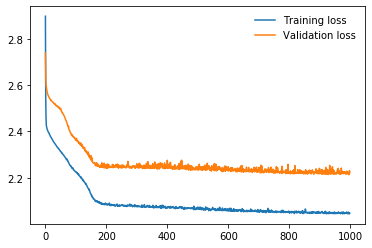

In [12]:
plt.plot(trainingLoss[:], label='Training loss')
plt.plot(validationLoss[:], label='Validation loss')
plt.legend(frameon=False)
plt.show()

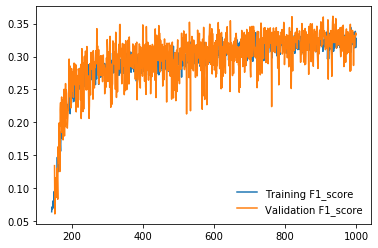

In [13]:
plt.plot(training_f1[:], label='Training F1_score')
plt.plot(validation_f1[:], label='Validation F1_score')
plt.legend(frameon=False)
plt.show()

In [14]:
def convert_1_to_3_channels(image):
    stacked_img = np.stack((image,)*3, axis=-1)
    return stacked_img    
    

[[[-0.41564286 -1.7269129  -2.341592   ... -2.4717987  -2.5841904
   -1.6123258 ]
  [-1.6923463  -3.817188   -4.1641655  ... -3.3856244  -3.3112905
   -2.4107883 ]
  [-1.6229614  -3.773041   -3.9869263  ... -3.3621724  -3.4126995
   -2.419294  ]
  ...
  [-1.509948   -3.4294019  -3.4310708  ... -4.1835523  -4.119266
   -1.8747002 ]
  [-1.4750041  -3.5748055  -3.797103   ... -3.994316   -4.0745683
   -2.0049617 ]
  [-0.7456786  -1.1837845  -1.1377704  ... -1.0471737  -1.3558815
   -0.44314352]]]


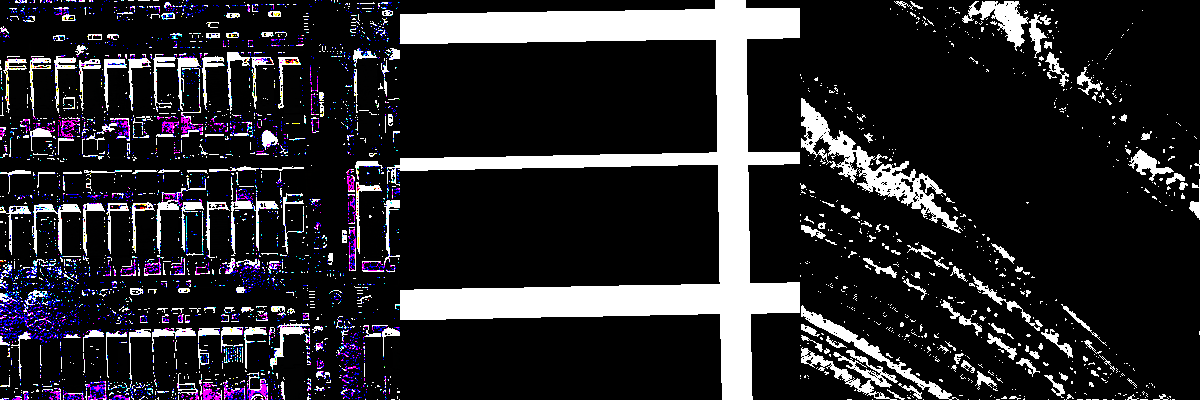

In [22]:
wantedNet = 999
net.load_state_dict(torch.load(path_to_models+'/net_Epoch_#' + str(wantedNet) +'.pt'))
if torch.cuda.is_available():
    print("cuda available!")
    net.cuda()
images, groundtruth = next(iter(testloader)) 
outputs = net(inputs)

image = images[0].numpy()
groundtruth = groundtruth[0].numpy()
print(outputs[0].detach().numpy())
net_result = outputs[0].detach().numpy()
net_result = net_result > 0
image = np.moveaxis(image, 0, 2)
groundtruth = np.moveaxis(groundtruth, 0, 2)
net_result = np.moveaxis(net_result, 0, 2)

image = image.astype("uint8")
groundtruth = groundtruth.astype("uint8")
net_result = net_result.astype("uint8")

groundtruth = groundtruth.reshape((400,400))*255
net_result = net_result.reshape((400,400))*255


groundtruth = convert_1_to_3_channels(groundtruth)
net_result = convert_1_to_3_channels(net_result)

compare = np.hstack([image, groundtruth, net_result])

compare = Image.fromarray(compare)

compare

